
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load particular Environment Adapter
from beacs.agents.CartPoleEnvironmentAdapter import CartPoleEnvironmentAdapter

# Load Metrics and Plotting Wrappers
from beacs.agents.beacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_cartpole_performance, \
    plot_average_cartpole_performance
from beacs.metrics import \
    _cartpole_metrics, \
    _mean_reliable_classifier_specificity

# Load environments
import gym

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
CLASSIFIER_LENGTH = 4
NUMBER_OF_POSSIBLE_ACTIONS = 2
CARTPOLE = "CartPole-v0" #CartPole-v1 goes up to 500 episodes

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 500
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
EPSILON = 0.5

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 100
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#BEACS Set Up
DO_GA = False
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 0
BETA_ALP = 0.05

## Environment - CartPole

In [3]:
# Initialize environment
CartPole = gym.make(CARTPOLE)
# Reset it, by putting an agent into random position
state = CartPole.reset()
print(CartPoleEnvironmentAdapter.to_genotype(CartPole,state))

('0', '0', '1', '1')


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    classifier_wildcard='#',
    environment_adapter=CartPoleEnvironmentAdapter,
    user_metrics_collector_fcn=_cartpole_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(CartPole, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 8.84 s, sys: 71.9 ms, total: 8.91 s
Wall time: 9.44 s


### Performance

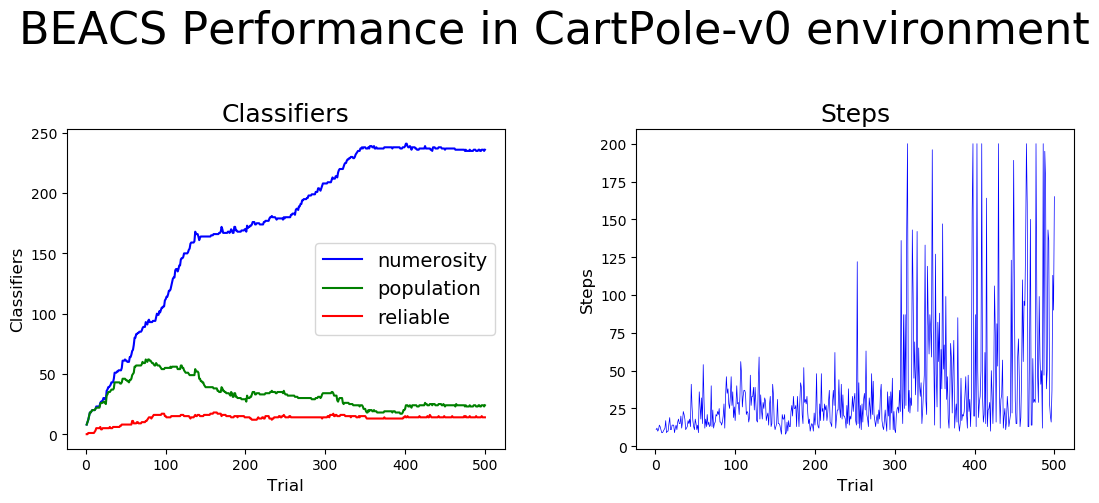

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_cartpole_performance(agent_explore, CartPole, metrics_df, cfg_explore, CARTPOLE, metrics_trial_frequency_explore, None)

In [6]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
print(len(population_explore_to_display))
print("\n")
for cl in population_explore_to_display[:5]:
    print(cl)
    print("\n")

24


##11 0 None (##22:#111, ####:#1724, ###2:#904) (0011)
q: 1.0    ra: 16.31  rb: 16.27  ir: 1.0    f: 16.31  err: 0.2243
exp: 2617  num: 12 ee: True PAI_state: 
tga: 18473 tbseq: 1146  talp: 18502 tav: 3.61   



##21 1 None (##10:#96, ####:#2198, ###0:#1103) (0021)
q: 1.0    ra: 16.3   rb: 16.24  ir: 1.0    f: 16.3   err: 0.2214
exp: 2335  num: 12 ee: True PAI_state: 
tga: 18477 tbseq: 7766  talp: 18483 tav: 3.723  



##20 0 None (###1:#756, ####:#134, ##11:#194, ##1#:#87) (empty)
q: 1.0    ra: 16.16  rb: 16.27  ir: 1.0    f: 16.27  err: 0.2818
exp: 1027  num: 20 ee: False PAI_state: 
tga: 18480 tbseq: 6741  talp: 18480 tav: 10.87  



##12 1 None (####:#125, ##2#:#120, ##21:#124, ###1:#338) (empty)
q: 1.0    ra: 16.09  rb: 16.14  ir: 1.0    f: 16.14  err: 0.3819
exp: 688   num: 20 ee: False PAI_state: 
tga: 18461 tbseq: 964   talp: 18506 tav: 13.39  



##21 0 None (####:#1067, ###2:#880, ##1#:#29) (empty)
q: 1.0    ra: 15.72  rb: 15.95  ir: 1.0    f: 15.95  err: 0.6163
exp: 1806

In [7]:
agent_explore.get_pai_states_memory()

[]

## Training of BEACS - Exploitation

In [8]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    classifier_wildcard='#',
    environment_adapter=CartPoleEnvironmentAdapter,
    user_metrics_collector_fcn=_cartpole_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(CartPole, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 2.83 s, sys: 25.8 ms, total: 2.85 s
Wall time: 3.87 s


In [9]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    classifier_wildcard='#',
    environment_adapter=CartPoleEnvironmentAdapter,
    user_metrics_collector_fcn=_cartpole_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_no_rl)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(CartPole, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 11.6 s, sys: 68.5 ms, total: 11.7 s
Wall time: 11.9 s


### Performance

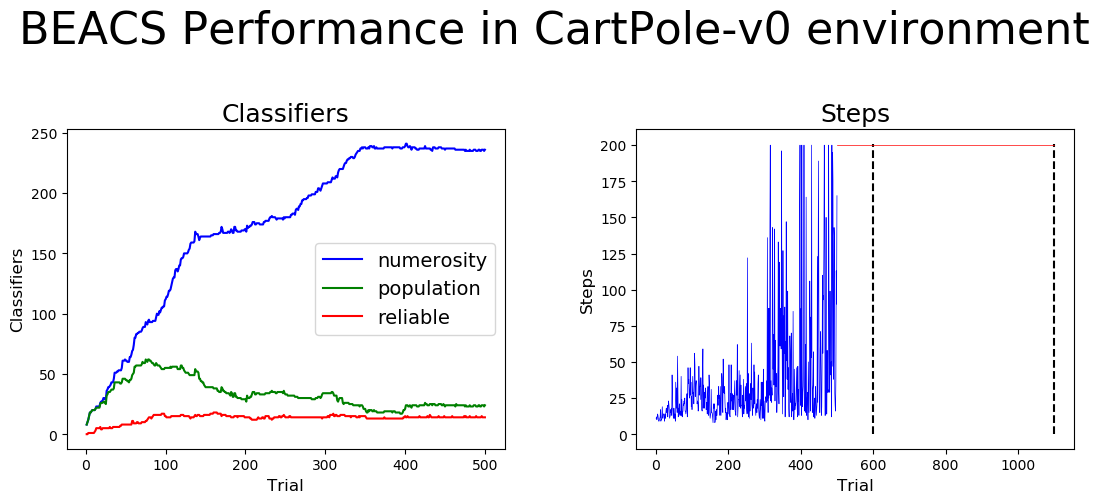

In [10]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_cartpole_performance(agent_exploit_rl, CartPole, metrics_df, cfg_exploit_rl, CARTPOLE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [11]:
trials=[]

avg_step_explore = 0
for trial in metrics_explore:
    trials.append(trial['steps_in_trial'])
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the cartpole is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

if NUMBER_OF_EXPLOIT_TRIALS_NO_RL:
    avg_step_exploit_no_rl = 0
    for trial in metrics_exploit_no_rl:
        trials.append(trial['steps_in_trial'])
        avg_step_exploit_no_rl += trial['steps_in_trial']
    avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    print("Average number of steps to solve the cartpole is ",avg_step_exploit_no_rl,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

if NUMBER_OF_EXPLOIT_TRIALS_RL:
    avg_step_exploit_rl = 0
    for trial in metrics_exploit_rl:
        trials.append(trial['steps_in_trial'])
        avg_step_exploit_rl += trial['steps_in_trial']
    avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
    print("Average number of steps to solve the cartpole is ",avg_step_exploit_rl,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_cartpole_metrics(population_explore, CartPole))
print(_cartpole_metrics(population_exploit_no_rl, CartPole))
print(_cartpole_metrics(population_exploit_rl, CartPole))

Average number of steps to solve the cartpole is  37.04  for a total of  500  trials in EXPLORATION
Average number of steps to solve the cartpole is  200.0  for a total of  100  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the cartpole is  200.0  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'population': 24, 'numerosity': 236, 'reliable': 14}
{'population': 24, 'numerosity': 236, 'reliable': 14}
{'population': 24, 'numerosity': 236, 'reliable': 14}


Solved requirements at episode 597 : average 196.05 for 100 episodes


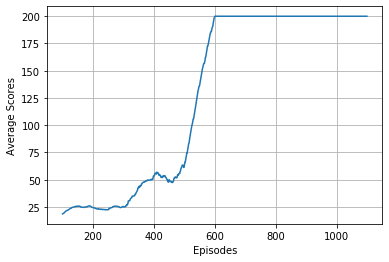

In [12]:
plot_average_cartpole_performance(trials)

In [13]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.behavioral_sequence or cl.is_enhanced()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display[:5]:
    print(cl)
    print("\n")

16


##20 0 None (###1:#756, ####:#134, ##11:#194, ##1#:#87) (empty)
q: 1.0    ra: 18.41  rb: 18.34  ir: 1.0    f: 18.41  err: 0.1316
exp: 1027  num: 20 ee: False PAI_state: 
tga: 18480 tbseq: 6741  talp: 18480 tav: 10.87  



##21 1 None (##10:#96, ####:#2198, ###0:#1103) (0021)
q: 1.0    ra: 18.4   rb: 18.38  ir: 1.0    f: 18.4   err: 0.08935
exp: 2335  num: 12 ee: True PAI_state: 
tga: 18477 tbseq: 7766  talp: 18483 tav: 3.723  



##12 1 None (####:#125, ##2#:#120, ##21:#124, ###1:#338) (empty)
q: 1.0    ra: 18.4   rb: 18.34  ir: 1.0    f: 18.4   err: 0.1464
exp: 688   num: 20 ee: False PAI_state: 
tga: 18461 tbseq: 964   talp: 18506 tav: 13.39  



##10 0 None (####:#589, ###1:#354) (empty)
q: 1.0    ra: 18.23  rb: 18.38  ir: 1.0    f: 18.38  err: 0.3574
exp: 942   num: 20 ee: False PAI_state: 
tga: 18453 tbseq: 614   talp: 18490 tav: 11.14  



##11 0 None (##22:#111, ####:#1724, ###2:#904) (0011)
q: 1.0    ra: 18.26  rb: 18.31  ir: 1.0    f: 18.31  err: 0.2112
exp: 2617  num: 12